# [Jansen-Rit whole brain CuPy implementation](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/jansen_rit_cupy.ipynb)


In [1]:
import torch
import pickle
import numpy as np
import networkx as nx
import sbi.utils as utils
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
from helpers import plot_ts_pxx_jr
from vbi.sbi_inference import Inference
from vbi.models.cupy.jansen_rit import JR_sde
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
from vbi import report_cfg
from vbi import extract_features_list
from vbi import get_features_by_domain, get_features_by_given_names

In [3]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed);

In [4]:
LABESSIZE = 12
plt.rcParams['axes.labelsize'] = LABESSIZE
plt.rcParams['xtick.labelsize'] = LABESSIZE
plt.rcParams['ytick.labelsize'] = LABESSIZE

In [5]:
nn = 6
num_sim = 100
num_workers = 10
weights = nx.to_numpy_array(nx.complete_graph(nn))

In [6]:
par = {
    "weights": weights,
    "t_cut": 500,
    "t_end": 2000,
    "noise_amp": 0.05,
    "dt": 0.02,
    "num_sim": num_sim,
    "engine": "cpu",
    "seed": seed,
    "same_initial_state": True,
}

In [7]:
obj = Inference()
G_min, G_max = 0.0, 5.0
C1_min, C1_max = 135, 300
prior_min = [G_min, C1_min]
prior_max = [G_max, C1_max]
prior = utils.BoxUniform(low=torch.tensor(prior_min),
                         high=torch.tensor(prior_max))
theta = obj.sample_prior(prior, num_sim)
theta_np = theta.numpy().astype(float)
G = theta_np[:, 0]
C1 = theta_np[:, 1]
C1 = np.tile(C1, (nn, 1))
par['G'] = G
par['C1'] = C1

In [8]:
jr = JR_sde(par)
# print(jr())

In [ ]:
data = jr.run()
print(data['x'].shape, data['t'].shape)
t = data['t']

(75000,) (6, 75000)


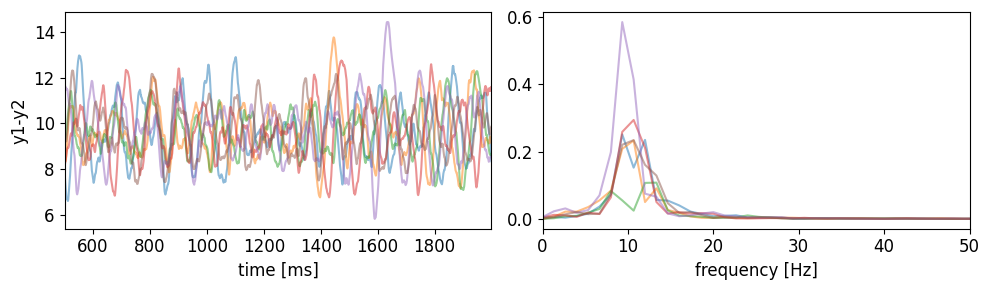

In [10]:
if 1:
    ts0 = data['x'][:, :, 0].T
    data0 = {"t": t, "x": ts0}
    info = np.isnan(ts0).sum()
    print(t.shape, ts0.shape)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    plot_ts_pxx_jr(data0, par, ax, alpha=0.5)
    plt.tight_layout()
    plt.savefig("output/jr_ts_psd.png", dpi=300)

In [11]:
cfg = get_features_by_domain(domain="statistical")
cfg = get_features_by_given_names(cfg, names=['calc_std', 'calc_mean'])
report_cfg(cfg)

Selected features:
------------------
■ Domain: statistical
 ▢ Function:  calc_std
   ▫ description:  Computes the standard deviation of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_std
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  calc_mean
   ▫ description:  Computes the mean of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_mean
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes


In [12]:
ts = data['x']             # [nt, nn, ns]
ts = ts.transpose(2, 1, 0) # [ns, nn, nt]
print(ts.shape)

(100, 6, 75000)


In [13]:
from vbi import extract_features
stat_vec = extract_features(ts=ts,
                                  cfg=cfg,
                                  fs=1/par['dt']*1000,
                                  n_workers=num_workers,
                                  verbose=False).values
stat_vec = np.array(stat_vec)
print(stat_vec.shape)

(100, 12)


In [14]:
scaler = StandardScaler()
stat_vec_st = scaler.fit_transform(stat_vec)
stat_vec_st = torch.tensor(stat_vec_st, dtype=torch.float32)
torch.save(theta, 'output/theta.pt')
torch.save(stat_vec_st, 'output/stat_vec_st.pt')
print(theta.shape, stat_vec_st.shape)

torch.Size([100, 2]) torch.Size([100, 12])


In [ ]:
posterior = obj.train(theta, stat_vec_st, prior, method='SNPE', density_estimator='maf')

In [16]:
with open('output/posterior.pkl', 'wb') as f:
    pickle.dump(posterior, f)

In [17]:
with open('output/posterior.pkl', 'rb') as f:
    posterior = pickle.load(f)

In [18]:
index = 0
theta_true = theta[index, :]
xo_st = stat_vec_st[index, :]

In [19]:
samples = obj.sample_posterior(xo_st, 10000, posterior)
torch.save(samples, 'output/samples.pt')

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

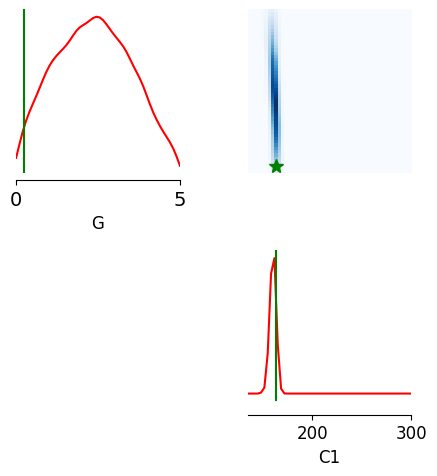

In [20]:
limits = [[i, j] for i, j in zip(prior_min, prior_max)]
fig, ax = pairplot(
    samples,
    limits=limits,
    figsize=(5, 5),
    points=theta_true,
    labels=["G", "C1"],
    offdiag='kde',
    diag='kde',
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"]),
    diag_kwargs={"mpl_kwargs": {"color": "r"}},
    upper_kwargs={"mpl_kwargs": {"cmap": "Blues"}},
)
ax[0,0].tick_params(labelsize=14)
ax[0,0].margins(y=0)
plt.tight_layout()
fig.savefig("output/tri_jr_cupy.jpeg", dpi=300)